In [36]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro import infer, poutine
from pyro.infer.autoguide import AutoNormal
from pyro.nn.module import PyroParam, PyroModule, PyroSample
from pyro.contrib.gp import Parameterized
plt.style.use("seaborn-v0_8")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
co2_df = pd.read_csv("/mnt/dl/machine_learning_dataset/atmospheric_co2_mauna_loa/monthly_in_situ_co2_mlo.csv",
                     skiprows=57)

In [38]:
co2_df

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally,Sta
0,,,,,,adjusted,,adjusted fit,filled,adjusted filled,NaN
1,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm],NaN
2,1958,01,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
3,1958,02,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
4,1958,03,21259,1958.2027,315.71,314.44,316.19,314.91,315.71,314.44,MLO
...,...,...,...,...,...,...,...,...,...,...,...
789,2023,08,45153,2023.6219,419.56,421.11,419.58,421.18,419.56,421.11,MLO
790,2023,09,45184,2023.7068,418.07,421.57,417.96,421.48,418.07,421.57,MLO
791,2023,10,45214,2023.7890,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
792,2023,11,45245,2023.8740,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO


In [39]:
co2_df.columns

Index(['  Yr', ' Mn', '    Date', '      Date', '     CO2', 'seasonally',
       '        fit', '  seasonally', '      CO2', ' seasonally', ' Sta'],
      dtype='object')

In [40]:
co2_df = co2_df.loc[2:,['  Yr', ' Mn', '     CO2',]]

In [41]:
new_cols = list(map(lambda x: x.strip(), co2_df.columns))

In [42]:
new_cols 

['Yr', 'Mn', 'CO2']

In [43]:
co2_df = co2_df.rename(columns=dict(zip(co2_df.columns, new_cols)))

In [44]:
co2_df

,Yr,Mn,CO2
2,1958,01,-99.99
3,1958,02,-99.99
4,1958,03,315.71
5,1958,04,317.45
6,1958,05,317.51
...,...,...,...
789,2023,08,419.56
790,2023,09,418.07
791,2023,10,-99.99
792,2023,11,-99.99


In [45]:
co2_df.Yr = co2_df.Yr.astype(int)
co2_df.Mn = co2_df.Mn.astype(int)
co2_df.CO2 = co2_df.CO2.astype(float)

In [46]:
# Drop Missing
data = co2_df.copy()
data = data[data["CO2"] != -99.99]

In [47]:
data

,Yr,Mn,CO2
4,1958,3,315.71
5,1958,4,317.45
6,1958,5,317.51
8,1958,7,315.87
9,1958,8,314.93
...,...,...,...
786,2023,5,423.78
787,2023,6,423.39
788,2023,7,421.62
789,2023,8,419.56


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 782 entries, 4 to 790
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Yr      782 non-null    int64  
 1   Mn      782 non-null    int64  
 2   CO2     782 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 24.4 KB


In [49]:
data["date"] = data.apply(lambda x: f"{int(x['Yr'])}-{int(x['Mn']):02d}", axis=1)

In [50]:
data

,Yr,Mn,CO2,date
4,1958,3,315.71,1958-03
5,1958,4,317.45,1958-04
6,1958,5,317.51,1958-05
8,1958,7,315.87,1958-07
9,1958,8,314.93,1958-08
...,...,...,...,...
786,2023,5,423.78,2023-05
787,2023,6,423.39,2023-06
788,2023,7,421.62,2023-07
789,2023,8,419.56,2023-08


/tmp/ipykernel_1424/263896264.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels()[::14], rotation=90)


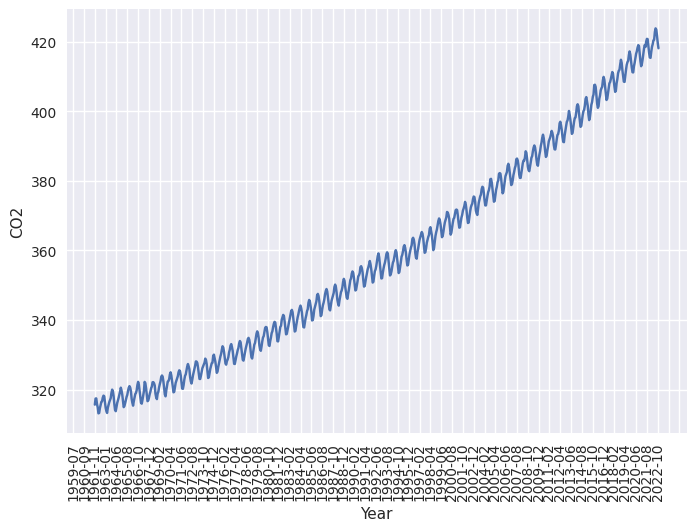

In [51]:
fig, ax = plt.subplots()
ax.plot(data["date"], data["CO2"])
ax.set_xlabel("Year")
ax.set_ylabel("CO2")
ax.set_xticklabels(ax.get_xticklabels()[::14], rotation=90)
locator = mpl.ticker.MultipleLocator(15)
ax.xaxis.set_major_locator(locator)

In [52]:
x = data.date.values.tolist()
y = torch.tensor(data.CO2.values).float()

In [53]:
ytrain = y.cuda()

In [54]:
yvar, ymean = torch.var_mean(ytrain)
yvar, ymean

(tensor(962.1697, device='cuda:0'), tensor(358.5257, device='cuda:0'))

In [55]:
ytrain.std()

tensor(31.0189, device='cuda:0')

In [56]:
ytrain_norm = (ytrain  - ymean) / yvar.sqrt()

In [57]:
ytrain_norm.mean(), ytrain_norm.std()

(tensor(4.8293e-07, device='cuda:0'), tensor(1., device='cuda:0'))

In [58]:
ytrain_norm[::100]

tensor([-1.3803, -1.2091, -0.8126, -0.5199, -0.1204,  0.4205,  0.8229,  1.4815],
       device='cuda:0')

In [59]:
class STSNet(PyroModule):
    
    def __init__(self, S, device=torch.device("cpu")):
        super().__init__()
        self.z = PyroSample(lambda self: dist.Normal(torch.tensor([0.0] * 2), torch.tensor(1.0)).to_event(1) )
        self.μ = PyroSample(lambda self: dist.LogNormal(0, 1.))
        self.δ = PyroSample(lambda self: dist.LogNormal(0, 1.))
        self.ϵ = PyroSample(lambda self: dist.LogNormal(0, 1.))
        
        self.transition_matrix = torch.tensor([[1., 1.], [0, 1]], device=device)
        self.obs_matrix = torch.tensor([1., 0], device=device)
        
        self.device = device
    
    def forward(self, y, values):
        # data_plate = pyro.plate("data", len(y))
        z = self.z
        for t in range(len(y)) :
            zmean = self.transition_matrix @ z.to(self.transition_matrix.device)
            
            z = pyro.sample(f"z_{t}", dist.Normal(zmean, torch.tensor([self.μ, self.δ], device=self.device)).to_event(1))
            ymean = self.obs_matrix @ z 
            if values is None:
                obs = pyro.sample(f"y_{t}", dist.Normal(ymean, self.ϵ), obs=y[t])
            else:
                obs = pyro.sample(f"y_{t}", dist.Normal(ymean, self.ϵ))
                
            if values is not None and isinstance(values, list):
                values.append(obs.item())

class CO2STS(PyroModule):
    
    def __init__(self, net, y):
        super().__init__()
        self.net = net
        self.y = torch.as_tensor(y)#[:2]

    def model(self, training=True):
        pyro.module("net", self)
        self.values = None
        if not training:
            self.values = []
        self.net(self.y, self.values)
        
        

In [60]:
pyro.clear_param_store()
pyro.set_rng_seed(10)
net = STSNet(S=12, device=torch.device("cuda:0")).cuda()

co2_model = CO2STS(net, y=ytrain_norm)
model = (
        # co2_model.model
        poutine.block(co2_model.model, 
                      # expose_fn=lambda x: "z" not in x["name"] 
                    #   expose_fn=expose_fn,
                    expose_fn=lambda x: "z_" not in x["name"]
                      )
        )
guide = AutoNormal(model)

In [61]:
with torch.no_grad():
    with poutine.block(), poutine.trace(param_only=True) as param_capture:
        guide()
        

params = list([pyro.param(name).unconstrained() for name in param_capture.trace])
loss_fn =  infer.Trace_ELBO().differentiable_loss
optimizer = torch.optim.Adam(params, lr=1e-3,)
print(list(pyro.get_param_store().items()))

[('AutoNormal.locs.net.z', Parameter containing:
tensor([0., 0.], requires_grad=True)), ('AutoNormal.scales.net.z', tensor([0.1000, 0.1000], grad_fn=<SoftplusBackward0>)), ('AutoNormal.locs.net.μ', Parameter containing:
tensor(0., requires_grad=True)), ('AutoNormal.scales.net.μ', tensor(0.1000, grad_fn=<SoftplusBackward0>)), ('AutoNormal.locs.net.δ', Parameter containing:
tensor(0., requires_grad=True)), ('AutoNormal.scales.net.δ', tensor(0.1000, grad_fn=<SoftplusBackward0>)), ('AutoNormal.locs.net.ε', Parameter containing:
tensor(0., requires_grad=True)), ('AutoNormal.scales.net.ε', tensor(0.1000, grad_fn=<SoftplusBackward0>))]


In [62]:
losses = []
for i in range(5):
    loss = loss_fn(co2_model.model, guide) / len(ytrain_norm)
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(params, 10.)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().item())

/env_nlp/lib/python3.9/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'z_1', 'z_73', 'z_177', 'z_514', 'z_231', 'z_356', 'z_224', 'z_430', 'z_442', 'z_556', 'z_169', 'z_278', 'z_461', 'z_275', 'z_168', 'z_366', 'z_431', 'z_662', 'z_733', 'z_6', 'z_60', 'z_347', 'z_209', 'z_685', 'z_206', 'z_46', 'z_220', 'z_353', 'z_519', 'z_397', 'z_470', 'z_132', 'z_610', 'z_113', 'z_174', 'z_233', 'z_466', 'z_563', 'z_779', 'z_770', 'z_40', 'z_331', 'z_202', 'z_565', 'z_721', 'z_691', 'z_598', 'z_645', 'z_97', 'z_346', 'z_655', 'z_497', 'z_624', 'z_751', 'z_420', 'z_144', 'z_642', 'z_547', 'z_654', 'z_200', 'z_68', 'z_139', 'z_270', 'z_315', 'z_524', 'z_554', 'z_710', 'z_735', 'z_544', 'z_0', 'z_77', 'z_539', 'z_765', 'z_176', 'z_729', 'z_333', 'z_147', 'z_310', 'z_487', 'z_313', 'z_449', 'z_527', 'z_24', 'z_585', 'z_653', 'z_314', 'z_54', 'z_709', 'z_400', 'z_769', 'z_121', 'z_377', 'z_705', 'z_37', 'z_674', 'z_459', 'z_149', 'z_622', 'z_579', 'z_10', 'z_164', 'z_3

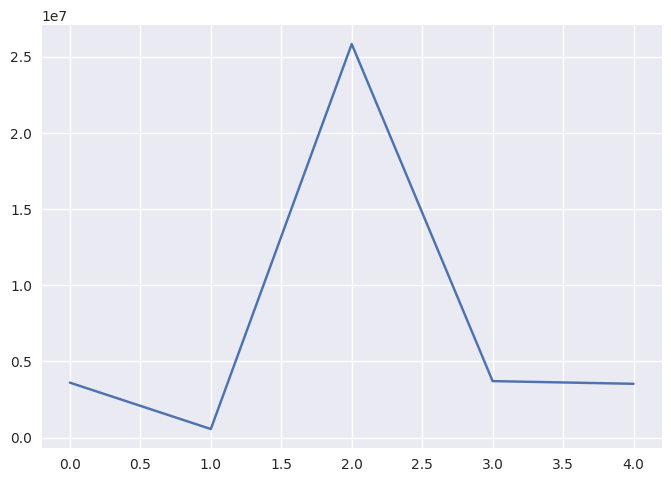

In [63]:
plt.plot(losses)

In [65]:
print(list(pyro.get_param_store().items()))

[('AutoNormal.locs.net.z', Parameter containing:
tensor([0.0012, 0.0039], requires_grad=True)), ('AutoNormal.scales.net.z', tensor([0.1003, 0.1002], grad_fn=<SoftplusBackward0>)), ('AutoNormal.locs.net.μ', Parameter containing:
tensor(-0.0037, requires_grad=True)), ('AutoNormal.scales.net.μ', tensor(0.1005, grad_fn=<SoftplusBackward0>)), ('AutoNormal.locs.net.δ', Parameter containing:
tensor(-0.0014, requires_grad=True)), ('AutoNormal.scales.net.δ', tensor(0.1005, grad_fn=<SoftplusBackward0>)), ('AutoNormal.locs.net.ε', Parameter containing:
tensor(0.0038, requires_grad=True)), ('AutoNormal.scales.net.ε', tensor(0.1002, grad_fn=<SoftplusBackward0>))]
